# Workshop Sandbox

This is a reference for how I imagine the workshop will go. Eventually this probably becomes the basis for the readme. 

## Sample question 1 with solution

question: "You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. You’ve heard stories about this region’s challenges, including specific dangers and advice for navigating safely. You decide to search your journal for past notes or consult historical accounts."

options:
- take the northern trail
- take the southern trail
- ask locals for more information

answer: take the southern trail

necessary info: "the northern trail was destroyed by a flood and is no longer safe to traverse"

In [51]:
ex_question = {
    "question": "You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?",
    "answer": "B",
    "options": ["A: take the northern trail", "B: take the southern trail", "C: turn around", "D: go fishing"],
}

In [52]:
from langchain_openai import OpenAIEmbeddings
from langchain_redis import RedisVectorStore
from langchain_core.documents import Document

doc = Document(page_content="the northern trail, of the blue mountains, was destroyed by a flood and is no longer safe to traverse. It is recommended to take the southern trail although it is longer.")

vectorstore = RedisVectorStore.from_documents([doc], OpenAIEmbeddings(), redis_url="redis://localhost:6379/0", index_name="oregon_trail")

In [53]:
retriever = vectorstore.as_retriever()

In [54]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information that is helpful for answering questions about what to do next on the Oregon Trail",
)

tools = [retriever_tool]

In [55]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [56]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_openai import ChatOpenAI
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    print(f"{docs=}")

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-3.5-turbo")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-3.5-turbo", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "You are an assistant playing the oregon trail. Use the following pieces of retrieved context to answer the question. You must select either A, B, C, or D as an answer return only the letter of the correct answer.",
                ),
                ("system", "Context: {context}"),
                ("human", "Question: {question} "),
            ]
        )

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [57]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

In [58]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

In [59]:
usr_question = f"question: {ex_question['question']}, options: {', '.join(ex_question['options'])}"
usr_question

'question: You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?, options: A: take the northern trail, B: take the southern trail, C: turn around, D: go fishing'

In [60]:
import pprint

inputs = {
    "messages": [("user", usr_question)],
}

for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_AibVGEd7JpcNeMXJbkI6jEWj', 'function': {'arguments': '{"query": "Oregon Trail dense forest northern trail"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}, {'index': 1, 'id': 'call_bkaqrH10fHHY62LPngZUHQK9', 'function': {'arguments': '{"query": "Oregon Trail dense forest southern trail"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-10b5e38c-0443-4343-8fee-c1c45a65b138-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Oregon Trail dense forest northern trail'}, 'id': 'call_AibVGEd7JpcNeMXJbkI6jEWj', 'type': 'tool_call'}, {'name': 'retrieve_blog_posts', 'args': {'query': 'Oregon Trail dense forest southern trail'}, 'id': 'call_bkaqrH10fHHY62LPngZUHQK9', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
docs

In [61]:
# creates retriever

class PlayerAgent:
    def answer_question(self, question):
        return "I don't know"


class OregonTrail:
    def __init__(self, player_agent: PlayerAgent):
        # workshop participant will implement this class
        self._agent = player_agent
    
    def sample_question(self):
        return

    def play_game(self):
        while True:
            print("Welcome to Oregon Trail!")
            print("You may:")
            print("1. Travel the trail")
            print("2. Learn more about the trail")
            print("3. End")
            choice = input("What is your choice? ")

            if choice == "1":
                self._retriever.get_next_location()
            elif choice == "2":
                self._retriever.get_info()
            elif choice == "3":
                break
            else:
                print("Invalid choice")

In [ ]:
# routing test
import os
from redisvl.extensions.router import Route, SemanticRouter
from redisvl.utils.vectorize import HFTextVectorizer

REDIS_URL = os.environ.get("REDIS_URL", "redis://localhost:6379/0")

# Semantic router
blocked_references = [
    "thinks about aliens",
    "corporate questions about agile",
    "anything about the S&P 500",
    "anything about crypto"
]

block_route = Route(name="block_list", references=blocked_references)

router = SemanticRouter(
    name="bouncer",
    vectorizer=HFTextVectorizer(),
    routes=[block_route],
    redis_url=REDIS_URL,
    overwrite=True,
)

In [11]:
route_match = router("Tell me about the S&P500?", distance_threshold=0.2)

In [12]:
route_match.name

'block_list'

In [1]:
import os
from final_example import ExampleAgent

graph = ExampleAgent().get_graph()

/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


09:45:02 redisvl.index.index INFO   Index already exists, overwriting.


/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python3.11/site-packages/transformers/models/mpnet/modeling_mpnet.py:1051: UserWarning: cumsum_out_mps supported by MPS on MacOS 13+, please upgrade (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/UnaryOps.mm:422.)
  incremental_indices = torch.cumsum(mask, dim=1).type_as(mask) * mask


09:45:03 redisvl.index.index INFO   Index already exists, not overwriting.
09:45:04 redisvl.index.index INFO   Index already exists, not overwriting.


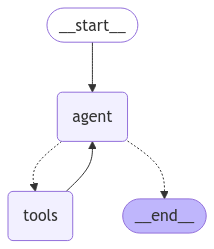

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass